In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re 
import keras
from sklearn.preprocessing import OneHotEncoder

from PIL import Image
import cv2

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Dense, Dropout, Flatten, Activation
from keras import optimizers
from tensorflow.keras.optimizers import schedules
from keras.preprocessing.image import ImageDataGenerator

In [2]:
train_filenames = []
test_filenames = []

for filename in glob.iglob('train/*/*'):
    train_filenames.append(filename)
    
for filename in glob.iglob('test/*/*'):
    test_filenames.append(filename)

In [3]:
train_images = []
train_labels = []

test_images = []
test_labels = []

for filename in train_filenames:
    image = cv2.imread(filename)
    image = image / 255
    train_images.append(image)
        
    label = re.search('(?<=\\\)([a-z]+)(?=\\\)', filename).group(0)
    train_labels.append(label)
    
for filename in test_filenames:
    image = cv2.imread(filename)
    image = image / 255
    test_images.append(image)
    
    label = re.search('(?<=\\\)([a-z]+)(?=\\\)', filename).group(0)
    test_labels.append(label)
    
train_images = np.array(train_images)
test_images = np.array(test_images)

In [4]:
num_classes = 7

onehot_encoder = OneHotEncoder(sparse=False)

train_labels = onehot_encoder.fit_transform(np.array(train_labels).reshape(-1, 1))
test_labels = onehot_encoder.fit_transform(np.array(test_labels).reshape(-1, 1))

In [5]:
p1 = np.random.permutation(len(train_images))
train_images = train_images[p1]
train_labels = train_labels[p1]

p2 = np.random.permutation(len(test_images))
test_images = test_images[p2]
test_labels = test_labels[p2]

In [6]:
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(include_top=False, input_shape=[48, 48, 3])

model = Sequential([
    vgg_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 9

In [7]:
opt = optimizers.RMSprop(learning_rate=0.0001, decay=0.0001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_images, train_labels, validation_split=0.2, batch_size=128, epochs=5)

Epoch 1/5
180/180 [==============================] - 567s 3s/step - loss: 1.8158 - accuracy: 0.2555 - val_loss: 1.5643 - val_accuracy: 0.3673
Epoch 2/5
180/180 [==============================] - 575s 3s/step - loss: 1.5228 - accuracy: 0.4029 - val_loss: 1.4017 - val_accuracy: 0.4810
Epoch 3/5
180/180 [==============================] - 574s 3s/step - loss: 1.3516 - accuracy: 0.4836 - val_loss: 1.2242 - val_accuracy: 0.5338
Epoch 4/5
180/180 [==============================] - 575s 3s/step - loss: 1.2290 - accuracy: 0.5432 - val_loss: 1.1375 - val_accuracy: 0.5815
Epoch 5/5
180/180 [==============================] - 571s 3s/step - loss: 1.1265 - accuracy: 0.5891 - val_loss: 1.1509 - val_accuracy: 0.5636


In [8]:
scores = model.evaluate(test_images, test_labels, batch_size=128)
print("Accuracy: %.2f%%" % (scores[1]*100))

57/57 [==============================] - 18s 317ms/step - loss: 1.1534 - accuracy: 0.5619
Accuracy: 56.19%


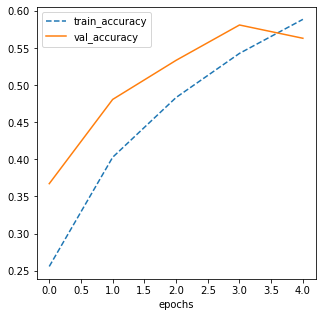

In [9]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(hist.history['accuracy'], ls='dashed', label='train_accuracy')
ax.set_xlabel("epochs")
ax.plot(hist.history['val_' + 'accuracy'], label='val_accuracy')
ax.legend()

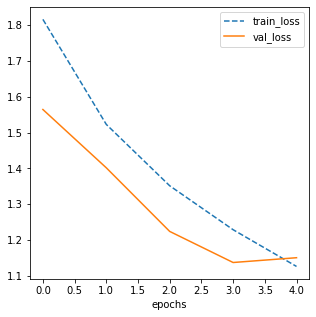

In [10]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(hist.history['loss'], ls='dashed', label='train_loss')
ax.set_xlabel("epochs")
ax.plot(hist.history['val_' + 'loss'], label='val_loss')
ax.legend()

In [11]:
test_img_fn1 = "t1.jpg"
test_img_fn2 = "t2.jpg"

images = []

test_image1 = cv2.imread(test_img_fn1)
test_image1 = cv2.resize(test_image1, (48, 48))
test_image1 = test_image1 / 255

test_image2 = cv2.imread(test_img_fn2)
test_image2 = cv2.resize(test_image2, (48, 48))
test_image2 = test_image2 / 255

images.append(test_image1)
images.append(test_image2)


images = np.array(images)

preds = model.predict(images)

1/1 [==============================] - 0s 158ms/step


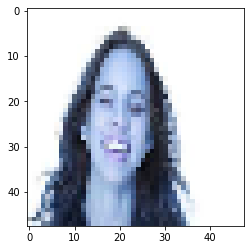

In [25]:
plt.imshow(test_image1)

In [22]:
classes = onehot_encoder.get_feature_names_out()

classes[np.argmax(preds[0])]

'x0_fearful'

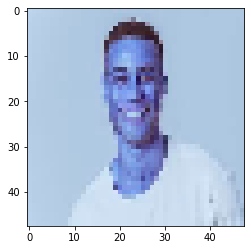

In [26]:
plt.imshow(test_image2)

In [20]:
classes[np.argmax(preds[1])]

'x0_angry'